In [24]:
# day21_quiz
# 집값 예측

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd', context='paper', spines=True, 
             ticks=True, grid=True, gridlines='dotted', figsize=(6,4.5))

In [9]:
house = pd.read_csv('data/q/HPA/train.csv')
house.head()
house.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [13]:
house = house[['price', 'sqft_living', 'bedrooms',\
             'bathrooms', 'sqft_lot', 'floors', 'zipcode']]
house.head()
# 필요 데이터 저장 

,price,sqft_living,bedrooms,bathrooms,sqft_lot,floors,zipcode
0,221900.0,1180,3,1.00,5650,1.0,98178
1,180000.0,770,2,1.00,10000,1.0,98028
2,510000.0,1680,3,2.00,8080,1.0,98074
3,257500.0,1715,3,2.25,6819,2.0,98003
4,291850.0,1060,3,1.50,9711,1.0,98198


In [17]:
## 정규화 ## 
# : 데이터의 범위를 0과 1로 변환하여 데이터 분포를 조정하는 법
## <->  표준화
# : 각 observation이 평균 기준으로 어느정도 떨어져있는지 나타낼때 사용 
# 두 변수 존재시, 스케일 차이를 제고해줌, 제로 평균으로부터 각 값들의 분산을 나타낸다. 
# 각 요소값에서 평균을 뺀 다음 표준 편차로 나누어준다 
for i in range(len(house.columns)): # 열의 수만큼 반복
    house.iloc[:,i] = (house.iloc[:,i] - np.min(house.iloc[:,i]))\
    / (np.max(house.iloc[:,i]) - np.min(house.iloc[:,i]))

In [19]:
house.describe() # 데이터 주요정보 

,price,sqft_living,bedrooms,bathrooms,sqft_lot,floors,zipcode
count,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,0.060704,0.135380,0.336914,0.264383,0.008951,0.199228,0.389049
std,0.048744,0.069595,0.090272,0.095940,0.025813,0.215409,0.269181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032013,0.086038,0.300000,0.218750,0.002730,0.000000,0.161616
50%,0.048806,0.122264,0.300000,0.281250,0.004301,0.200000,0.323232
75%,0.074390,0.171321,0.400000,0.312500,0.006164,0.400000,0.585859
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


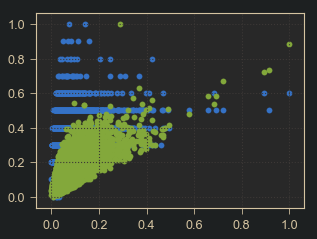

In [25]:
plt.scatter(house['price'],house['bedrooms'])
plt.scatter(house['price'],house['sqft_living'])

In [32]:
############# x,y 나누기 #############
y_data = house.iloc[:,0].values.reshape(-1,1) # 행렬을 바꿔서 보기좋게 만들어요
y_data
# series 객체는 values를 써야해요 ! 

array([[0.01887956],
       [0.01338231],
       [0.05667804],
       ...,
       [0.03699816],
       [0.04224613],
       [0.03240619]])

In [61]:
x_data1 = house.iloc[:,1].values.reshape(-1,1)
x_data1

array([[0.06716981],
       [0.03622642],
       [0.10490566],
       ...,
       [0.09358491],
       [0.15245283],
       [0.05509434]])

In [37]:
x_data2 = house.iloc[:,1:4].values.reshape(-1,3)
 # sqft_living|bedrooms|bathrooms
x_data2

array([[0.06716981, 0.3       , 0.125     ],
       [0.03622642, 0.2       , 0.125     ],
       [0.10490566, 0.3       , 0.25      ],
       ...,
       [0.09358491, 0.3       , 0.3125    ],
       [0.15245283, 0.4       , 0.3125    ],
       [0.05509434, 0.2       , 0.09375   ]])

In [40]:
x_data3 = house.iloc[:,1:].values.reshape(-1,6)
x_data3

array([[6.71698113e-02, 3.00000000e-01, 1.25000000e-01, 3.10751079e-03,
        0.00000000e+00, 8.93939394e-01],
       [3.62264151e-02, 2.00000000e-01, 1.25000000e-01, 5.74253455e-03,
        0.00000000e+00, 1.36363636e-01],
       [1.04905660e-01, 3.00000000e-01, 2.50000000e-01, 4.57948958e-03,
        0.00000000e+00, 3.68686869e-01],
       ...,
       [9.35849057e-02, 3.00000000e-01, 3.12500000e-01, 3.70114833e-04,
        8.00000000e-01, 5.15151515e-01],
       [1.52452830e-01, 4.00000000e-01, 3.12500000e-01, 3.20624846e-03,
        4.00000000e-01, 7.32323232e-01],
       [5.50943396e-02, 2.00000000e-01, 9.37500000e-02, 3.36798440e-04,
        4.00000000e-01, 7.22222222e-01]])

In [50]:
def training(x_train, y_train, x_test, lr=0.001, epochs=5000):
# 한번에 5000개 사진으로 학습결과
    ncol_x = x_train.shape[-1] # x의 열갯수
    ncol_y = y_train.shape[-1] # y의 열갯수
    
    x = tf.placeholder(tf.float32, shape = (None, ncol_x), name='x')
    y = tf.placeholder(tf.float32, shape = (None, ncol_y), name='y')
    w = tf.Variable(tf.random_normal(shape=[ncol_x,ncol_y]), name='weight')
    b = tf.Variable(tf.random_normal(shape=[1]), name='bias')
    
    hf = tf.matmul(x,w) + b
    
    cost = tf.reduce_mean(tf.square(hf-y))
    train = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    term = round(epochs/20)
    
    for epoch in range(epochs):
        
        if epoch % term == 0:
            print("["+("="*round(epoch/term)) + ">" +" "*(20 - round(epoch/term))+"]")
            print("cost :", sess.run(cost, feed_dict = {x:x_train, y:y_train}))

        elif epoch == epochs - 1:
            print("["+("="*round(epoch/term)) + ">" +" "*(20 - round(epoch/term))+"]")
            print("cost :", sess.run(cost, feed_dict = {x:x_train, y:y_train}))
        
        sess.run(train, feed_dict = {x:x_train, y:y_train})
    y_pred = sess.run(hf, feed_dict = {x:x_test})
    return y_pred

In [62]:
x_data = x_data1
x_train, x_test = train_test_split(x_data, test_size=0.2, 
                                   shuffle = True, random_state=42) 
# 자동으로 표본을 무작위로 선택해 훈련 데이터와 평가 데이터를 나눈다 
y_train, y_test =  train_test_split(y_data, test_size=0.2, 
                                   shuffle = True, random_state=42)
y_pred = training(x_train, y_train, x_test, lr=0.05, epochs = 5000)

[>                    ]
cost : 0.39299878
[=>                   ]
cost : 0.002066451
[==>                  ]
cost : 0.001885092
[===>                 ]
cost : 0.0017424128
[====>                ]
cost : 0.0016301634
[=====>               ]
cost : 0.0015418541
[======>              ]
cost : 0.0014723795
[=======>             ]
cost : 0.0014177213
[========>            ]
cost : 0.0013747215
[=========>           ]
cost : 0.0013408924
[==========>          ]
cost : 0.0013142776
[===========>         ]
cost : 0.0012933392
[============>        ]
cost : 0.0012768666
[=============>       ]
cost : 0.0012639075
[==============>      ]
cost : 0.001253712
[===============>     ]
cost : 0.001245691
[================>    ]
cost : 0.0012393809
[=================>   ]
cost : 0.0012344166
[==================>  ]
cost : 0.0012305107
[===================> ]
cost : 0.0012274383
[====================>]
cost : 0.0012250294


In [63]:
plt.figure(figsize=(8,8))


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

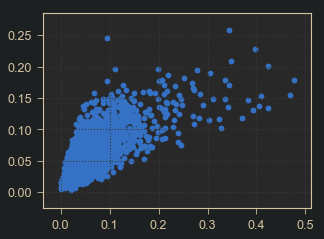

In [64]:
plt.scatter(y_test, y_pred)


(-0.2, 1)

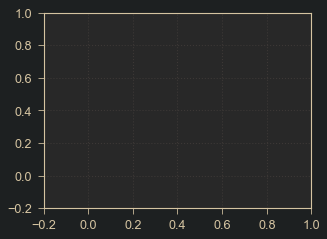

In [65]:
# plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.xlim(-0.2, 1)
plt.ylim(-0.2, 1)

In [66]:
x_data = x_data2
x_train, x_test = train_test_split(x_data, test_size=0.2, shuffle = True, random_state=42)
y_train, y_test = train_test_split(y_data, test_size=0.2, shuffle = True, random_state=42)
y_pred = training(x_train, y_train, x_test, lr=0.01, epochs = 50000)


[>                    ]
cost : 0.43683743
[=>                   ]
cost : 0.018952189
[==>                  ]
cost : 0.013033871
[===>                 ]
cost : 0.009109631
[====>                ]
cost : 0.006498214
[=====>               ]
cost : 0.0047570528
[======>              ]
cost : 0.0035943924
[=======>             ]
cost : 0.0028167968
[========>            ]
cost : 0.0022957402
[=========>           ]
cost : 0.0019457513
[==========>          ]
cost : 0.0017099482
[===========>         ]
cost : 0.0015504638
[============>        ]
cost : 0.0014420706
[=============>       ]
cost : 0.0013679516
[==============>      ]
cost : 0.0013168886
[===============>     ]
cost : 0.0012813881
[================>    ]
cost : 0.0012564382
[=================>   ]
cost : 0.0012386797
[==================>  ]
cost : 0.0012258567
[===================> ]
cost : 0.0012164485
[====================>]
cost : 0.0012094298


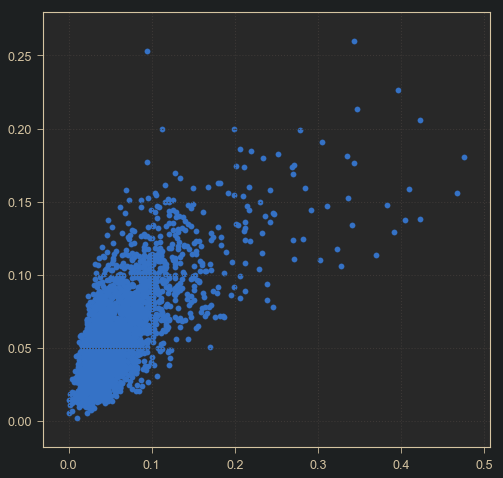

In [69]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)


(-0.2, 1)

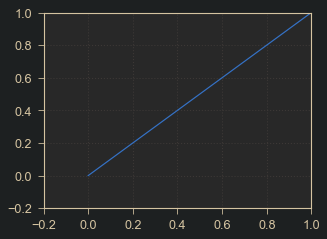

In [71]:
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.xlim(-0.2,1)
plt.ylim(-0.2,1)

In [72]:
x_data = x_data3
x_train, x_test = train_test_split(x_data, test_size=0.2, shuffle = True, random_state=42)
y_train, y_test = train_test_split(y_data, test_size=0.2, shuffle = True, random_state=42)
y_pred = training(x_train, y_train, x_test, lr=0.1, epochs = 50000)


[>                    ]
cost : 0.7758264
[=>                   ]
cost : 0.0015349935
[==>                  ]
cost : 0.0012205115
[===>                 ]
cost : 0.0011753329
[====>                ]
cost : 0.001164209
[=====>               ]
cost : 0.0011609618
[======>              ]
cost : 0.0011598663
[=======>             ]
cost : 0.0011594363
[========>            ]
cost : 0.0011592449
[=========>           ]
cost : 0.0011591522
[==========>          ]
cost : 0.0011591057
[===========>         ]
cost : 0.0011590816
[============>        ]
cost : 0.0011590689
[=============>       ]
cost : 0.0011590627
[==============>      ]
cost : 0.0011590591
[===============>     ]
cost : 0.0011590573
[================>    ]
cost : 0.0011590563
[=================>   ]
cost : 0.0011590559
[==================>  ]
cost : 0.0011590555
[===================> ]
cost : 0.0011590555
[====================>]
cost : 0.0011590553


(-0.2, 1)

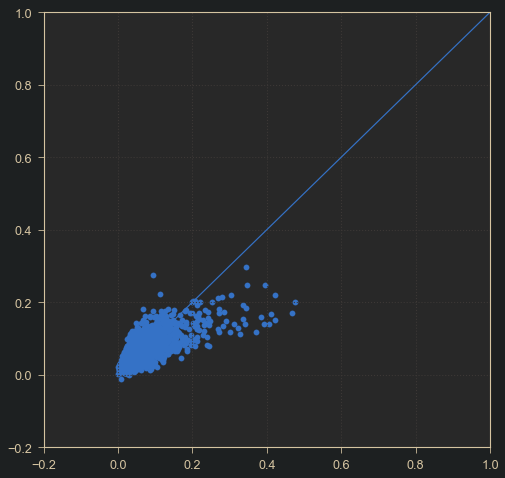

In [82]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.xlim(-0.2,1)
plt.ylim(-0.2,1)